In [4]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from PIL import Image
import torchvision.transforms as T
from torchvision.models import densenet121, DenseNet121_Weights
from tqdm import tqdm
import matplotlib.pyplot as plt

In [5]:
# 1. Загружаем CSV
# -------------------
csv1 = pd.read_csv("dataset/meta_data_normal.csv", encoding="utf-8")      # Normal
csv2 = pd.read_csv("dataset/meta_data_cap.csv", encoding="latin-1")  # Pneumonia
csv3 = pd.read_csv("dataset/meta_data_covid.csv", encoding="latin-1") # COVID-19

# Добавляем метки классов
csv1["label"] = 0
csv2["label"] = 1
csv3["label"] = 2

# Объединяем в один DataFrame
df = pd.concat([csv1, csv2, csv3], ignore_index=True)

# -------------------
# 2. Делим на train/val/test (84% / 8% / 8%)
# -------------------
train_df, temp_df = train_test_split(
    df, test_size=0.16, stratify=df["label"], random_state=42
)

val_df, test_df = train_test_split(
    temp_df, test_size=0.5, stratify=temp_df["label"], random_state=42
)

print(f"Train: {len(train_df)} | Val: {len(val_df)} | Test: {len(test_df)}")

Train: 14367 | Val: 1368 | Test: 1369


In [6]:
# 3. Класс датасета
# -------------------
class ChestCTDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        img_path = os.path.join(self.img_dir, row["File name"])
        image = Image.open(img_path).convert("RGB")
        label = int(row["label"])

        if self.transform:
            image = self.transform(image)

        return image, label

In [7]:
# 4. Трансформации
# -------------------
transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


In [8]:
# 5. Датасеты и DataLoader
# -------------------
img_dir = "dataset/images/"  # путь к папке с изображениями

train_dataset = ChestCTDataset(train_df, img_dir, transform)
val_dataset   = ChestCTDataset(val_df, img_dir, transform)
test_dataset  = ChestCTDataset(test_df, img_dir, transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [9]:
# 6. Модель
# -------------------
def get_model(num_classes=3, pretrained=True):
    weights = DenseNet121_Weights.DEFAULT if pretrained else None
    model = densenet121(weights=weights)
    in_f = model.classifier.in_features
    model.classifier = nn.Linear(in_f, num_classes)
    return model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"⚡ Используется устройство: {device}")

model = get_model(3).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

⚡ Используется устройство: cuda


In [10]:
# 7. Циклы обучения и валидации
# -------------------
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    loop = tqdm(dataloader, desc="Training", leave=False)
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        loop.set_postfix(loss=loss.item(), acc=(correct / total))
    return running_loss / total, correct / total

In [11]:
def evaluate(model, dataloader, criterion, device, phase="Validation"):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    loop = tqdm(dataloader, desc=phase, leave=False)
    with torch.no_grad():
        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            loop.set_postfix(loss=loss.item(), acc=(correct / total))
    return running_loss / total, correct / total

In [12]:
# 8. Обучение
# -------------------
num_epochs = 10
train_losses, val_losses, test_losses = [], [], []
train_accuracies, val_accuracies, test_accuracies = [], [], []

best_val_acc = 0.0
best_model_path = "best_densenet_ct.pth"

for epoch in range(num_epochs):
    print(f"\n🔹 Epoch {epoch+1}/{num_epochs}")
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device, phase="Validation")
    test_loss, test_acc = evaluate(model, test_loader, criterion, device, phase="Test")

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    test_losses.append(test_loss)

    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    test_accuracies.append(test_acc)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), best_model_path)
        print(f"✅ Сохранена новая лучшая модель (val_acc={val_acc:.4f})")

    print(f"Train: loss={train_loss:.4f}, acc={train_acc:.4f} | "
          f"Val: loss={val_loss:.4f}, acc={val_acc:.4f} | "
          f"Test: loss={test_loss:.4f}, acc={test_acc:.4f}")


🔹 Epoch 1/10


✅ Сохранена новая лучшая модель (val_acc=0.9817)
Train: loss=0.1776, acc=0.9362 | Val: loss=0.0558, acc=0.9817 | Test: loss=0.0622, acc=0.9810

🔹 Epoch 2/10


✅ Сохранена новая лучшая модель (val_acc=0.9942)
Train: loss=0.0559, acc=0.9822 | Val: loss=0.0210, acc=0.9942 | Test: loss=0.0309, acc=0.9920

🔹 Epoch 3/10


Train: loss=0.0318, acc=0.9898 | Val: loss=0.0221, acc=0.9912 | Test: loss=0.0424, acc=0.9890

🔹 Epoch 4/10


Train: loss=0.0201, acc=0.9937 | Val: loss=0.0289, acc=0.9890 | Test: loss=0.0333, acc=0.9905

🔹 Epoch 5/10


Train: loss=0.0205, acc=0.9935 | Val: loss=0.0227, acc=0.9920 | Test: loss=0.0413, acc=0.9883

🔹 Epoch 6/10


✅ Сохранена новая лучшая модель (val_acc=0.9949)
Train: loss=0.0188, acc=0.9941 | Val: loss=0.0117, acc=0.9949 | Test: loss=0.0251, acc=0.9927

🔹 Epoch 7/10


✅ Сохранена новая лучшая модель (val_acc=0.9971)
Train: loss=0.0017, acc=0.9999 | Val: loss=0.0083, acc=0.9971 | Test: loss=0.0226, acc=0.9956

🔹 Epoch 8/10


Train: loss=0.0117, acc=0.9962 | Val: loss=0.1074, acc=0.9635 | Test: loss=0.1133, acc=0.9649

🔹 Epoch 9/10


Train: loss=0.0260, acc=0.9912 | Val: loss=0.0205, acc=0.9942 | Test: loss=0.0362, acc=0.9912

🔹 Epoch 10/10


Train: loss=0.0053, acc=0.9985 | Val: loss=0.0314, acc=0.9927 | Test: loss=0.0324, acc=0.9912


In [13]:
# 9. Загружаем лучшую модель
# -------------------
model.load_state_dict(torch.load(best_model_path, map_location=device))
print(f"🎯 Загружена лучшая модель с val_acc={best_val_acc:.4f}")

🎯 Загружена лучшая модель с val_acc=0.9971


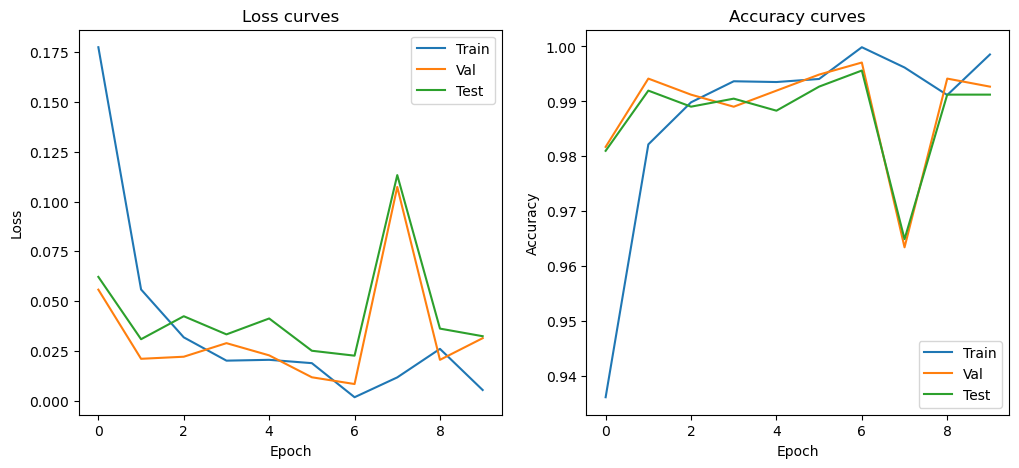

In [14]:
# 10. Графики
# -------------------
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(train_losses, label="Train")
plt.plot(val_losses, label="Val")
plt.plot(test_losses, label="Test")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss curves")
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accuracies, label="Train")
plt.plot(val_accuracies, label="Val")
plt.plot(test_accuracies, label="Test")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy curves")
plt.legend()

plt.show()

In [20]:
# Классы (обнови под свой датасет)
class_names = ["COVID-19", "CAP", "Normal"]

def predict_image(model, image_path, device):
    img = Image.open(image_path).convert("RGB")
    img = transform(img).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        outputs = model(img)
        probs = torch.softmax(outputs, dim=1)
        conf, pred = torch.max(probs, 1)

    return class_names[pred.item()], conf.item() * 100

def predict_folder(model, folder_path, device):
    results = []
    for fname in os.listdir(folder_path):
        if fname.lower().endswith((".png", ".jpg", ".jpeg")):
            path = os.path.join(folder_path, fname)
            label, confidence = predict_image(model, path, device)
            results.append((fname, label, confidence))
            print(f"{fname}: {label} ({confidence:.2f}%)")
    return results

In [21]:
from torchvision import models

In [22]:
model = models.densenet121(weights="IMAGENET1K_V1")
in_f = model.classifier.in_features
model.classifier = nn.Linear(in_f, len(class_names))
model.load_state_dict(torch.load("best_densenet_ct.pth", map_location=device))
model = model.to(device)

In [26]:
# Прогоняем папку
results = predict_folder(model, "postDICOM", device)

10000E6B_anon.png: Normal (99.97%)
10000E6C_anon.png: Normal (99.97%)
10000E6D_anon.png: Normal (99.97%)
10000E6E_anon.png: Normal (99.96%)
10000E6F_anon.png: Normal (99.96%)
10000E70_anon.png: Normal (99.96%)
10000E71_anon.png: Normal (99.97%)
10000E72_anon.png: Normal (99.96%)
10000E73_anon.png: Normal (99.96%)
10000E74_anon.png: Normal (99.96%)
10000E75_anon.png: Normal (99.95%)
10000E76_anon.png: Normal (99.95%)
10000E77_anon.png: Normal (99.92%)
10000E78_anon.png: Normal (99.93%)
10000E79_anon.png: Normal (99.90%)
10000E7A_anon.png: Normal (99.89%)
10000E7B_anon.png: Normal (99.87%)
10000E7C_anon.png: Normal (99.90%)
10000E7D_anon.png: Normal (99.93%)
10000E7E_anon.png: Normal (99.95%)
10000E7F_anon.png: Normal (99.94%)
10000E80_anon.png: Normal (99.90%)
10000E81_anon.png: Normal (99.93%)
10000E82_anon.png: Normal (99.96%)
10000E83_anon.png: Normal (99.94%)
10000E84_anon.png: Normal (99.92%)
10000E85_anon.png: Normal (99.91%)
10000E86_anon.png: Normal (99.92%)
10000E87_anon.png: N